<a href="https://colab.research.google.com/github/alonsomoros/colab/blob/main/2_2_2_Auto_encoders_Mi_primer_AE_Convolucional_con_Keras_Enunciado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div><img style="float: right; width: 80px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Mi primer AE Convolucional con Keras<a id="top"></a>

<i><small>Authors: Félix José Fuentes Hurtado<br>Last update: 2023-09-29</small></i></div>

***

### Mi primer AutoEncoder Convolucional con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder convolucional paso a paso. Todos los ejemplos están extraídos del propio blog de Keras, aquí tenéis el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta.

Comenzemos recordando qué es un autoencoder convolucional. Para ello, mirad la imagen siguiente:

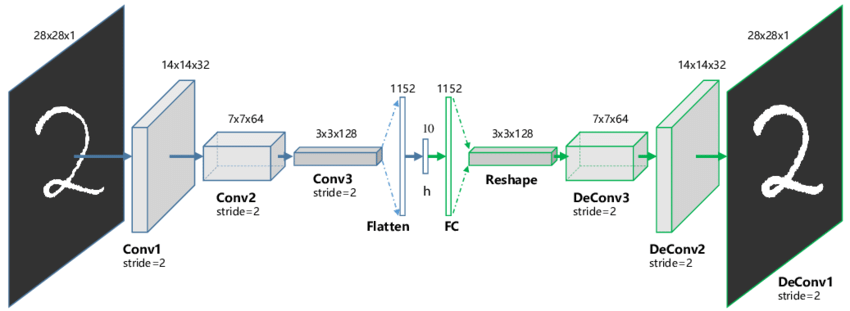

En ella podemos observar como consta de dos bloques: el encoder y el decoder.

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta.

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

A lo largo de esta práctica implementaremos un autoencoder convolucional y visualizaremos el espacio latente ("bottleneck").

¡Nueva capa!

[UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/)

Ejemplo size=(32,32), interpolation='bilinear'

![Ejemplo](https://raw.githubusercontent.com/christianversloot/machine-learning-articles/main/images/simple_upsampling.png)


Para aumentar la resolución trabajamos con UpSampling2D + Conv2D. Hay otra capa de Conv2DTranspose que hace los dos pasos al mismo tiempo. Conv2DTranspose aprende parámetros de cómo realizar el aumento (Similar a Conv2D con strides).

**¡Comenzemos!**

Vamos a implementar nuestro primer autoencoder convolucional. La arquitectura del autoencoder será la siguiente:

Para el encoder:

- Capa Convolucional, 16 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 8 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`

Para el decoder:

- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 8 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 16 filtros de 3x3, activación `ReLU` y padding `valid`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 1 filtros de 3x3, activación `sigmoid` y padding `same`


**Pregunta**: ¿Qué tamaño tendrá el bottleneck?

**Respuesta**: 4x4x8

**Pregunta**: ¿Por qué escogemos `padding=valid` en la penúltima capa convolucional del decoder? Te ayudará calcular las dimensiones de entrada y salida de cada capa.

**Respuesta**: Porque al usar el 2º UpSampling se nos queda en 16x16x8 que usando padding valid se nos rebaja 14x14x8 y que para los siguientes pasos nos viene bien para acabar en la dimension de 28x28x1.

In [21]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2,2), padding='same')(x)



x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(8,(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16,(3, 3), activation='relu', padding='valid')(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Ahora obtendremos las imágenes y las normalizaremos entre 0 y 1: dividiremos entre 255, ya que las imágenes están codificadas con 8 bits sin signo (uint8).

In [22]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255

Como vamos a trabajar con imágenes, tenemos que redimensionar los datos para que tengan 2 dimensiones: de 786 a (28, 28, 1), porque son imágenes en escala de grises.

In [23]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Tras esto, entrenamos nuestro DC (Deep Convolutional) AutoEncoder:

*(Atención: ahora es importante tener seleccionada GPU o TPU, de lo contrario el entrenaiento será muy lento)*

In [24]:
logs = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3541 - val_loss: 0.1751
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1681 - val_loss: 0.1523
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1507 - val_loss: 0.1425
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1423 - val_loss: 0.1370
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1373 - val_loss: 0.1328
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1331 - val_loss: 0.1299
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1302 - val_loss: 0.1272
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1276 - val_loss: 0.1249
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1258 - val_loss: 0.1232
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1243 - val_loss: 0.1220
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1231 - val_loss: 0.1208
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/ste

También podemos visualizar las curvas de entrenamiento, que se guardan en la variable history:

In [25]:
logs.history.keys()

dict_keys(['loss', 'val_loss'])

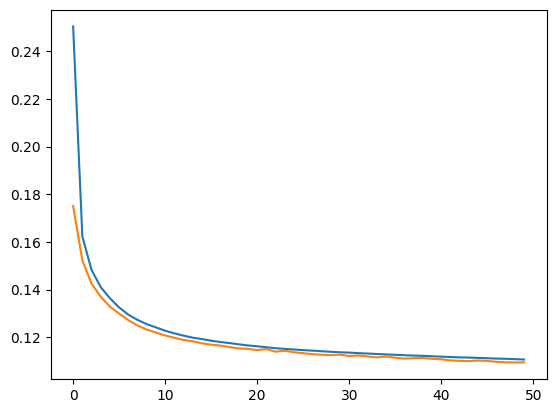

In [26]:
import matplotlib.pyplot as plt

plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


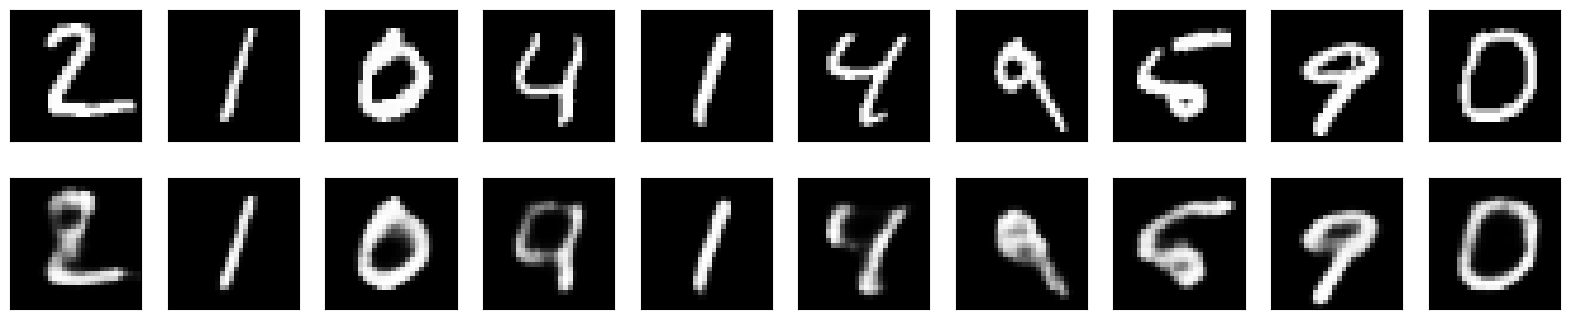

In [27]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Además, podemos también mirar las representaciones obtenidas por el encoder, las cuales tienen unas dimensiones de 8x8x4.

Para poder visualizarlas en 2D, las redimensionaremos a 4x32.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


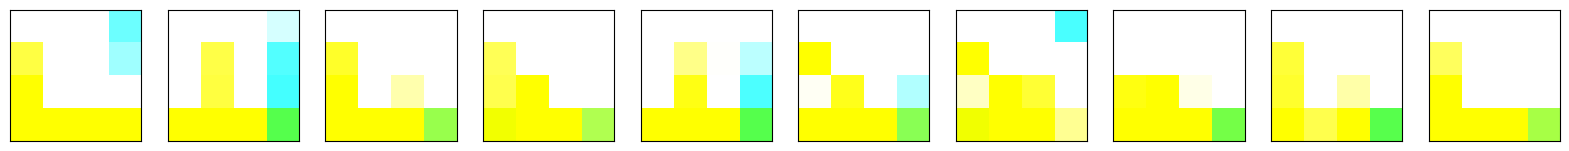

In [31]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.squeeze(encoded_imgs[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

En teoría, en estas representaciones se encuentra la información necesaria para reconstruir los datos originales con el menor error posible.